# Modeling of strength of high-performance concrete using regression models

In [668]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler

from sklearn.dummy import DummyRegressor

from src.utils import fit_model_return_cv_score, perform_grid_search, rfecv_feature_selection

## Python Scripts

In [669]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV

def fit_model_return_cv_score(model, X_train, y_train, cv=10):
    """
    Fit the model on training data, compute CV score, and return the fitted model and test score.
    """
    # Perform cross-validation on the training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    cv_mean = cv_scores.mean()
    print("CV mean score:", cv_mean)
    
    # Fit final model on full training set
    model.fit(X_train, y_train)
    
    return cv_mean, model

def perform_grid_search(model, param_grid, X_train, y_train, cv=10):
    """
    Perform GridSearchCV on the given model and parameter grid and plot the results.
    """ 
    results = []    
    gridsearch = GridSearchCV(model, param_grid, cv=cv, scoring='r2', return_train_score=True)
    gridsearch.fit(X_train, y_train)

    results = pd.DataFrame(gridsearch.cv_results_)
    plt.figure(figsize=(4, 3))
    plt.plot(results['param_alpha'], results['mean_test_score'], marker='o')
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Mean CV R^2 Score')
    plt.title(f'{model.__class__.__name__} CV Results')
    plt.grid()
    plt.show()

    print("Best alpha:", gridsearch.best_params_['alpha'])
    print("Train R^2:", gridsearch.best_score_)

    return gridsearch.best_score_, gridsearch.best_params_, gridsearch.best_estimator_

def rfecv_feature_selection(estimator, X_train, y_train, cv=10):
    """
    Perform RFECV feature selection and return the selector and best score.
    """
    selector = RFECV(estimator, cv=cv, scoring='r2')
    selector.fit(X_train, y_train)
    print(f"Optimal number of features: {selector.n_features_}")
    print(f"Selected features: {X_train.columns[selector.support_]}")
    best_score = selector.cv_results_['mean_test_score'].max()
    print(f"Best R^2 score: {best_score}")
    return selector, best_score

## Contents

- [Introduction / Dataset Description](#introduction--dataset-description)
- [Analysis Objective](#analysis-objective)
- [EDA](#eda)
- [Modelling](#modelling)
- [Model Comparison](#model-comparison)
- [Findings & Interpretation](#findings--interpretation)
- [Evaluation & Future Steps](#evaluation--future-steps)

## Introduction

This dataset contains 1,030 observations of high-performance concrete samples, each described by 8 material composition variables and the curing age (days). The target variable is compressive strength (MPa). The goal of this analysis is to build a regression model capable of predicting concrete strength based on mixture composition while also identifying which predictors influence strength most strongly.


## Analysis Objective

The objective is two-fold:
1.	Predictive – develop a model that generalizes well to unseen concrete mixtures.
2.	Interpretive – quantify the relative importance of cement, slag, fly ash, aggregates, etc., and determine whether simplifying the model (via feature selection or regularization) affects performance.

## EDA

In [670]:
df = pd.read_excel('data/Concrete_Data.xls')
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In this step, we load the raw concrete dataset from an Excel file into a pandas DataFrame so we can examine its structure and values. 

The original column names are long, inconsistent, and contain units inside the labels, which makes them difficult to reference in code. To make the dataset cleaner and easier to work with, we rename the columns using shorter, standardized names (e.g., Cement, Water, Age, Compressive Strength). 

We are only updating the headers, no data values are changed, so the dataset remains exactly the same, just more readable for the rest of the analysis.

In [671]:
df.rename(columns={"Cement (component 1)(kg in a m^3 mixture)": "Cement", 
                   "Blast Furnace Slag (component 2)(kg in a m^3 mixture)": "Blast Furnace Slag",
                   "Fly Ash (component 3)(kg in a m^3 mixture)": "Fly Ash",
                   "Water  (component 4)(kg in a m^3 mixture)": "Water",
                   "Superplasticizer (component 5)(kg in a m^3 mixture)": "Superplasticizer",
                   "Coarse Aggregate  (component 6)(kg in a m^3 mixture)": "Coarse Aggregate",
                   "Fine Aggregate (component 7)(kg in a m^3 mixture)": "Fine Aggregate",
                   "Age (day)": "Age",
                   "Concrete compressive strength(MPa, megapascals) ": "Compressive Strength"
                   }, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cement                1030 non-null   float64
 1   Blast Furnace Slag    1030 non-null   float64
 2   Fly Ash               1030 non-null   float64
 3   Water                 1030 non-null   float64
 4   Superplasticizer      1030 non-null   float64
 5   Coarse Aggregate      1030 non-null   float64
 6   Fine Aggregate        1030 non-null   float64
 7   Age                   1030 non-null   int64  
 8   Compressive Strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


We use `df.info()` to check the structure of the dataset, including the number of rows, columns, data types, and the presence of missing values. This confirms that the dataset contains 1,030 samples and 9 numeric features, with no null entries, meaning no imputation is required. It also shows that most variables are stored as float64, except for Age which is an integer. This step ensures the data is clean and ready for preprocessing.

In [672]:
df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Compressive Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Above is a summary statistics for each feature, allowing us to understand the central tendency, spread, and range of the data. This helps identify potential skewness (e.g., Fly Ash and Superplasticizer have many zeros), unusually wide ranges (Age varies from 1 to 365 days), and outliers. 

These insights guide later transformation decisions such as scaling, log transformation, or Box-Cox normalization.

Next, we will visualize the distribution of every feature in the dataset and statistically test whether each variable follows a normal distribution. For each feature, we plot a histogram, compute its skewness, and apply the D’Agostino normality test. The p-value is compared against alpha = 0.05 to classify the feature as Normal or Not Normal. This helps us decide which variables need transformation before modeling. The results show that most predictors exhibit noticeable skewness and deviate from normality, especially Age, Superplasticizer, and Fly Ash.

Since linear models assume approximately symmetric, homoscedastic predictors, this analysis justifies applying targeted transformations in the preprocessing stage.


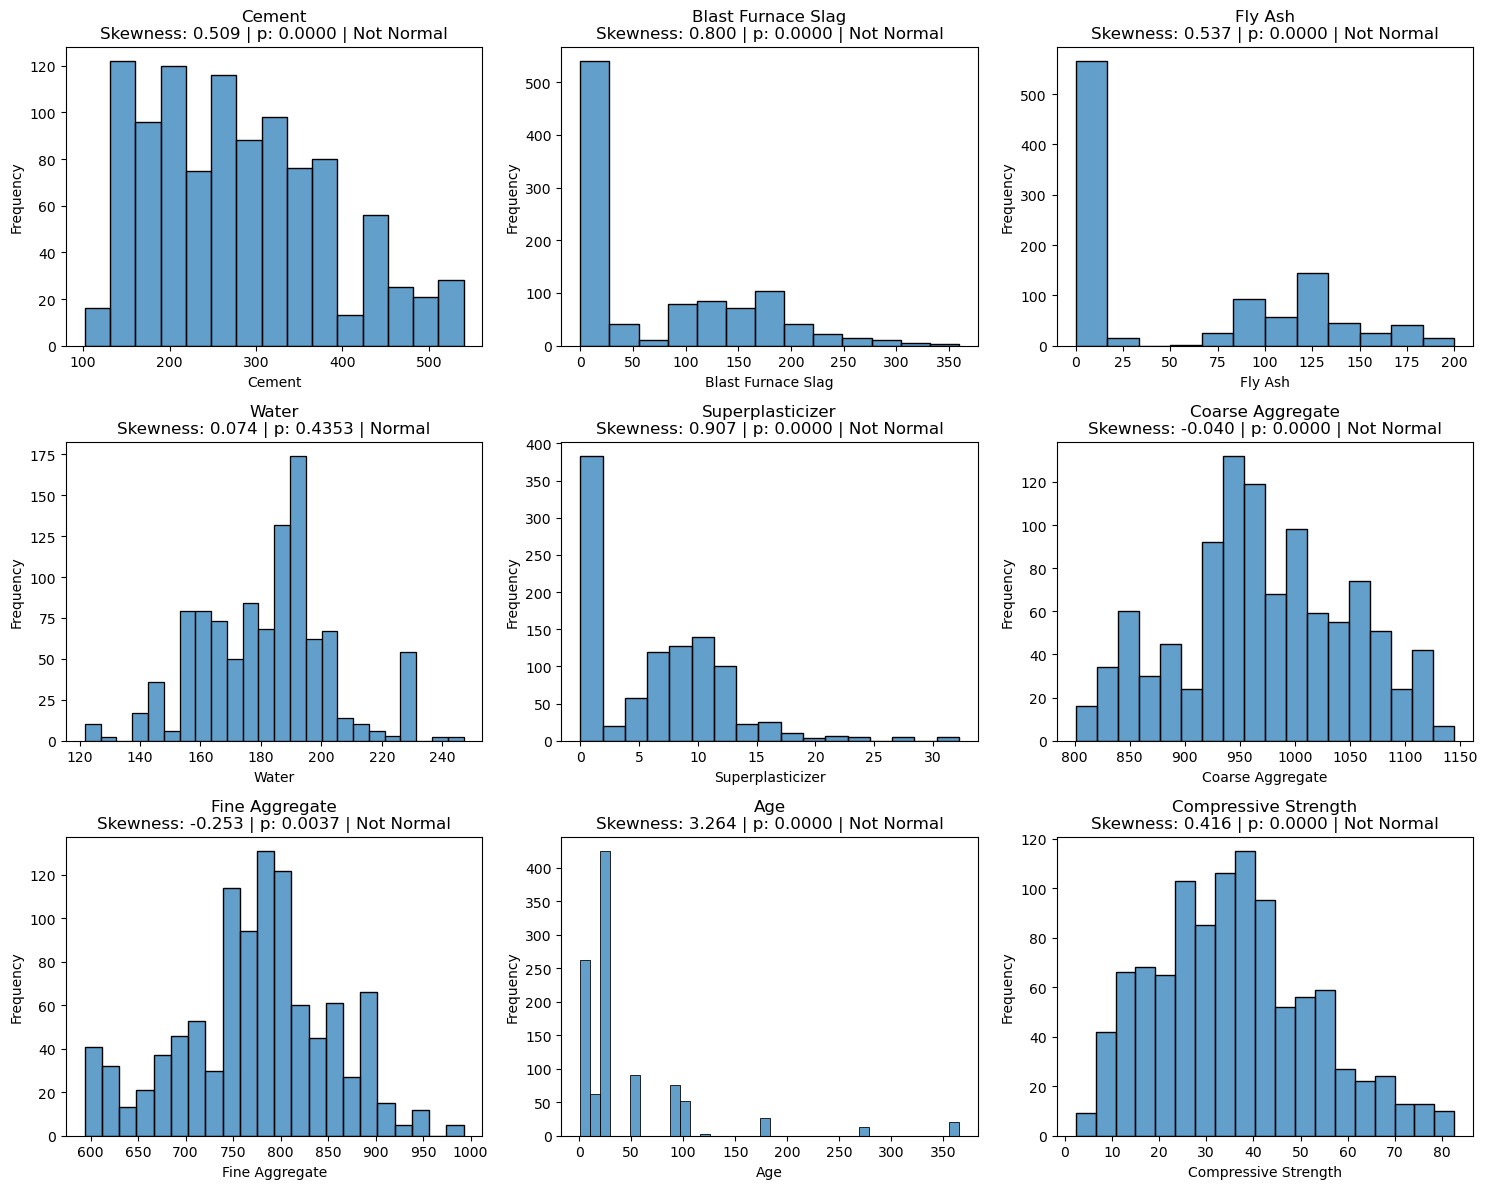

In [673]:
alpha = 0.05

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    sns.histplot(df[column], alpha=0.7, ax=ax)
    
    skewness = stats.skew(df[column])
    shapiro_stat, p_value = stats.normaltest(df[column])
    
    is_normal = "Normal" if p_value >= alpha else "Not Normal"
    
    ax.set_title(f'{column}\nSkewness: {skewness:.3f} | p: {p_value:.4f} | {is_normal}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [674]:
X = df.drop("Compressive Strength", axis=1)
y = df["Compressive Strength"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- BoxCox transform Cement
    - Cement values are strictly positive
	- Skew is moderate (not extreme), Box-Cox usually works very well here
	- Goal: make distribution more symmetric for linear models
- Box-Cox transform Blast Furnace Slag
    - Same logic as above: positive values + moderate skew = Box-Cox improves linearity and variance stability
- Log transform Fly Ash
    - Fly ash contains many low or zero values → log1p is ideal
	- Log transform is simpler and widely used for chemical dosage variables
	- Box-Cox cannot be applied when zeros exist without shifting
- No transform on water
    - No skew issue, transforming would add unnecessary noise and harm interpretability
- BoxCox transform on Superplasticizer
    - Because values are strictly positive and skewed
- No transform on Coarse Aggregate
    - Distribution is already symmetric and roughly bell-shaped according to skewness
- No transform on Fine Aggregate
    - Slight skew but still acceptable; transformation may hurt interpretability more than it helps
- Yeo-Johnson transform on Age
    - Age includes zeros (cannot use Box-Cox)
	- Yeo-Johnson handles zero & negative values safely
	- Strong skew: transformation is necessary
- No transform on Concrete Strength (target)
    - Skew is small
	- Linear models can still handle mild skew
	- Keeping original units preserves interpretability
	- Metrics (RMSE, MAE) stay in real-world units (MPa)

In [675]:
passthrough_transformations = ["Water", "Coarse Aggregate", "Fine Aggregate"]

ct_transform = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), ["Fly Ash"]),
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), ["Age", "Cement", "Blast Furnace Slag", "Superplasticizer"]),
        ('passthrough', 'passthrough', passthrough_transformations)
    ], remainder='drop'
)
transformed_X_train = ct_transform.fit_transform(X_train)
transformed_X_test = ct_transform.transform(X_test)

In this step, we apply targeted transformations to reduce skewness and make the predictors more suitable for linear modeling. We use a ColumnTransformer to apply different transformations to different variables in a single pipeline:
- log1p() is applied to Fly Ash, which contains zeros and is strongly right-skewed.
- Yeo-Johnson power transform is applied to Age, Cement, Blast Furnace Slag, and Superplasticizer, because these variables are positive and heavily skewed.
- Water, Coarse Aggregate, and Fine Aggregate are passed through unchanged because their distributions were already approximately symmetric.

The result is a transformed version of X_train and X_test where each column has been adjusted to better satisfy the assumptions of linear regression models, while preserving interpretability.

In [676]:
transformed_X_train = pd.DataFrame(transformed_X_train, columns=ct_transform.get_feature_names_out()).join(y_train.reset_index(drop=True))
transformed_X_test = pd.DataFrame(transformed_X_test, columns=ct_transform.get_feature_names_out()).join(y_test.reset_index(drop=True))
transformed_X_train

,log__Fly Ash,yeojohnson__Age,yeojohnson__Cement,yeojohnson__Blast Furnace Slag,yeojohnson__Superplasticizer,passthrough__Water,passthrough__Coarse Aggregate,passthrough__Fine Aggregate,Compressive Strength
0,4.762174,0.105778,-1.279722,1.018175,1.250653,175.10,953.3,719.70,27.681082
1,4.890349,0.105778,1.244819,0.222562,0.642013,178.00,822.0,750.00,62.052840
2,4.806886,-1.664976,0.079506,-1.057010,0.796505,159.48,1053.6,777.50,23.800712
3,4.343805,0.105778,-0.145731,0.835725,0.585884,194.00,835.0,821.00,33.398217
4,4.830312,-1.664976,-1.131360,0.487695,0.889708,158.33,1080.8,796.15,7.398077
...,...,...,...,...,...,...,...,...,...
819,0.000000,-1.664976,0.183565,1.146747,0.925269,144.70,1004.6,803.70,24.400556
820,4.836917,-0.491262,-0.198522,-1.057010,0.998585,143.30,1086.8,800.89,42.216615
821,4.837709,1.257511,-0.844114,-1.057010,0.794437,166.61,1079.0,798.90,33.563692
822,0.000000,0.105778,1.565733,0.921799,0.689411,181.10,852.1,781.50,68.299493


## Scaling

In [677]:
scaling_feats = ["log__Fly Ash", "passthrough__Water", "passthrough__Coarse Aggregate", "passthrough__Fine Aggregate"]

ct_scale = ColumnTransformer(
    transformers=[
        ["scale", StandardScaler(), scaling_feats]
    ], remainder='passthrough'
)

ct_transformed_scaled_X_train = ct_scale.fit_transform(transformed_X_train.drop("Compressive Strength", axis=1))
ct_transformed_scaled_X_test = ct_scale.transform(transformed_X_test.drop("Compressive Strength", axis=1))

ct_transformed_scaled_X_train = pd.DataFrame(ct_transformed_scaled_X_train, columns=ct_scale.get_feature_names_out()).join(y_train.reset_index(drop=True))
ct_transformed_scaled_X_test = pd.DataFrame(ct_transformed_scaled_X_test, columns=ct_scale.get_feature_names_out()).join(y_test.reset_index(drop=True))
ct_transformed_scaled_X_train

,scale__log__Fly Ash,scale__passthrough__Water,scale__passthrough__Coarse Aggregate,scale__passthrough__Fine Aggregate,remainder__yeojohnson__Age,remainder__yeojohnson__Cement,remainder__yeojohnson__Blast Furnace Slag,remainder__yeojohnson__Superplasticizer,Compressive Strength
0,1.126860,-0.314231,-0.257457,-0.647505,0.105778,-1.279722,1.018175,1.250653,27.681082
1,1.180947,-0.178148,-1.926947,-0.273130,0.105778,1.244819,0.222562,0.642013,62.052840
2,1.145727,-1.047204,1.017866,0.066649,-1.664976,0.079506,-1.057010,0.796505,23.800712
3,0.950319,0.572657,-1.761651,0.604117,0.105778,-0.145731,0.835725,0.585884,33.398217
4,1.155612,-1.101168,1.363716,0.297081,-1.664976,-1.131360,0.487695,0.889708,7.398077
...,...,...,...,...,...,...,...,...,...
819,-0.882658,-1.740760,0.394827,0.390365,-1.664976,0.183565,1.146747,0.925269,24.400556
820,1.158400,-1.806455,1.440006,0.355646,-0.491262,-0.198522,-1.057010,0.998585,42.216615
821,1.158734,-0.712627,1.340829,0.331058,1.257511,-0.844114,-1.057010,0.794437,33.563692
822,-0.882658,-0.032679,-1.544223,0.116071,0.105778,1.565733,0.921799,0.689411,68.299493


After applying the power and log transformations, we standardize only the variables that remained on their original scale (Water, Coarse Aggregate, and Fine Aggregate) and log transformed Fly Ash. These features have different magnitudes compared to the transformed ones, so scaling them using StandardScaler (mean = 0, std = 1) ensures that all predictors are on a comparable range before modeling.

We use another ColumnTransformer so scaling is applied only to the selected features, while the already-transformed columns are passed through unchanged. The result is a fully processed dataset that is now ready for regression modeling.

In [678]:
X_train = ct_transformed_scaled_X_train.drop("Compressive Strength", axis=1)
y_train = ct_transformed_scaled_X_train["Compressive Strength"]
X_test = ct_transformed_scaled_X_test.drop("Compressive Strength", axis=1)
y_test = ct_transformed_scaled_X_test["Compressive Strength"]

## Modelling

### Baseline

In [679]:
dr = DummyRegressor()
score_dr, dr = fit_model_return_cv_score(dr, X_train, y_train)

CV mean score: -0.008544936306411089


We first establish a baseline using DummyRegressor, which predicts the mean compressive strength for all samples.
The cross-validated R^2 score is slightly negative (approx. -0.0085), indicating that this naive model performs no better than a constant prediction.

Any model with an R^2 above 0 provides value beyond the baseline

### Linear Regression with no Regularization

In [680]:
lr = LinearRegression()
score_lr, fitted_lr = fit_model_return_cv_score(lr, X_train, y_train)

CV mean score: 0.793746195160902


In [681]:
selector_lr, best_score_lr_rfecv = rfecv_feature_selection(lr, X_train, y_train)

Optimal number of features: 6
Selected features: Index(['scale__passthrough__Water', 'scale__passthrough__Fine Aggregate',
       'remainder__yeojohnson__Age', 'remainder__yeojohnson__Cement',
       'remainder__yeojohnson__Blast Furnace Slag',
       'remainder__yeojohnson__Superplasticizer'],
      dtype='object')
Best R^2 score: 0.7946067917946573


In [682]:
X_train_reduced_lr = selector_lr.transform(X_train)
X_test_reduced_lr = selector_lr.transform(X_test)

In [683]:
print(f'{best_score_lr_rfecv - score_lr:.6f} improvement in R^2 on training set')

0.000861 improvement in R^2 on training set


RFECV was applied to the Linear Regression model to automatically identify the most relevant predictors by iteratively removing the least useful features and evaluating performance through cross-validation. The procedure selected 6 out of the 9 original features, slightly improving the cross-validated R² score from 0.793746 to 0.794607 (an increase of just 0.000861). This very small gain indicates that the removed features contributed little predictive value and were likely redundant, meaning the model performs almost equally well with fewer inputs. While RFECV did not meaningfully boost accuracy, it provides a more compact and interpretable feature set, showing that Linear Regression can be simplified without sacrificing performance.

### Linear Regression with L1-regularization

In [684]:
l = Lasso(alpha=0.1)
score_l, fitted_lasso = fit_model_return_cv_score(l, X_train, y_train)

CV mean score: 0.7937778906731106


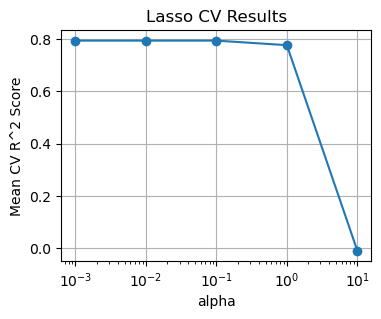

Best alpha: 0.1
Train R^2: 0.7937778906731106


In [685]:
param_grid_l = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

best_score_l, best_params_l, best_estimator_l = perform_grid_search(Lasso(), param_grid_l, X_train, y_train)

In [686]:
selector_l, best_score_lasso_rfecv = rfecv_feature_selection(best_estimator_l, X_train, y_train)

Optimal number of features: 6
Selected features: Index(['scale__passthrough__Water', 'scale__passthrough__Fine Aggregate',
       'remainder__yeojohnson__Age', 'remainder__yeojohnson__Cement',
       'remainder__yeojohnson__Blast Furnace Slag',
       'remainder__yeojohnson__Superplasticizer'],
      dtype='object')
Best R^2 score: 0.7946027295081153


In [687]:
X_train_reduced_lasso = selector_l.transform(X_train)
X_test_reduced_lasso = selector_l.transform(X_test)

In [688]:
print(f'{best_score_lasso_rfecv - score_l:.6f} improvement in R^2 on training set')

0.000825 improvement in R^2 on training set


We first fitted a baseline Lasso model with alpha=0.1, which produced a cross-validated R² score of 0.79378, almost identical to the unregularized Linear Regression model. To check whether tuning the regularization strength could improve performance, we ran GridSearchCV over a range of alpha values. The results showed that very small alphas (≤ 0.1) performed best, while larger alphas caused the model to underfit sharply, confirming that only light regularization is suitable for this dataset. The best alpha found was 0.1, meaning the tuned model is effectively the same as the baseline. Applying RFECV to the tuned Lasso model reduced the feature set from 9 to 6 predictors and gave a very small increase in CV R² (≈ +0.0008), showing that regularization plus feature elimination did not meaningfully improve performance. Overall, Lasso did not provide a performance gain, but it confirmed that only a small penalty is needed and helped identify a more compact set of relevant features.

### Linear Regression with L2-regularization

In [689]:
r = Ridge(alpha=1.0)
score_r, fitted_ridge = fit_model_return_cv_score(r, X_train, y_train)

CV mean score: 0.7937755445595591


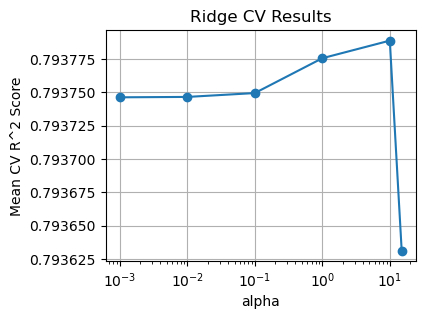

Best alpha: 10
Train R^2: 0.793788741354764


In [690]:
param_grid_r = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 15]
}

best_score_r, best_params_r, best_estimator_r = perform_grid_search(Ridge(), param_grid_r, X_train, y_train)

In [691]:
selector_r, best_score_ridge_rfecv = rfecv_feature_selection(best_estimator_r, X_train, y_train)

Optimal number of features: 6
Selected features: Index(['scale__passthrough__Water', 'scale__passthrough__Fine Aggregate',
       'remainder__yeojohnson__Age', 'remainder__yeojohnson__Cement',
       'remainder__yeojohnson__Blast Furnace Slag',
       'remainder__yeojohnson__Superplasticizer'],
      dtype='object')
Best R^2 score: 0.7946134073866609


In [692]:
X_train_reduced_ridge = selector_r.transform(X_train)
X_test_reduced_ridge = selector_r.transform(X_test)

In [693]:
print(f'{best_score_ridge_rfecv - score_r:.6f} improvement in R^2 on training set')

0.000838 improvement in R^2 on training set


We fitted a baseline Ridge Regression model with alpha=1.0, which achieved a cross-validated R² score of 0.79378, again almost identical to both Linear Regression and Lasso. We then tuned the regularization strength using GridSearchCV over a range of alpha values and found that performance was nearly flat across small alphas, with the best value being alpha = 10, giving a marginal increase in CV R² to 0.79379—a difference so small it is effectively negligible. After tuning, RFECV reduced the model to the same 6 features selected by the other models, resulting in an extremely small improvement of +0.00083 in R², confirming that Ridge behaves similarly to Lasso on this dataset: regularization has almost no effect because multicollinearity and overfitting are not major issues. Overall, Ridge offers no meaningful performance gain but, like Lasso, provides a slightly simpler model with redundant features removed.

### ElasticNet

In [694]:
en = ElasticNet(alpha=0.1, l1_ratio=0.5)
score_en, fitted_en = fit_model_return_cv_score(en, X_train, y_train)

CV mean score: 0.791726163966074


In [695]:
param_grid_en = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

results = []    
gridsearch = GridSearchCV(ElasticNet(), param_grid_en, cv=10, scoring='r2', return_train_score=True)
gridsearch.fit(X_train, y_train)

results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
7,0.000665,0.000052,0.000369,0.000006,0.01,0.3,"{'alpha': 0.01, 'l1_ratio': 0.3}",0.765933,0.753907,0.794151,...,0.801219,0.805806,0.795362,0.799607,0.798628,0.800657,0.800127,0.802430,0.801551,0.003349
6,0.000728,0.000107,0.000409,0.000037,0.01,0.1,"{'alpha': 0.01, 'l1_ratio': 0.1}",0.765798,0.753517,0.794376,...,0.801173,0.805764,0.795322,0.799565,0.798586,0.800621,0.800084,0.802389,0.801509,0.003349
8,0.000626,0.000033,0.000365,0.000006,0.01,0.5,"{'alpha': 0.01, 'l1_ratio': 0.5}",0.766057,0.754293,0.793914,...,0.801255,0.805839,0.795395,0.799640,0.798662,0.800686,0.800160,0.802463,0.801584,0.003349
9,0.000623,0.000025,0.000378,0.000025,0.01,0.7,"{'alpha': 0.01, 'l1_ratio': 0.7}",0.766166,0.754676,0.793663,...,0.801282,0.805864,0.795419,0.799665,0.798687,0.800708,0.800185,0.802487,0.801608,0.003349
10,0.000620,0.000036,0.000359,0.000008,0.01,0.9,"{'alpha': 0.01, 'l1_ratio': 0.9}",0.766267,0.755054,0.793399,...,0.801299,0.805880,0.795434,0.799680,0.798702,0.800721,0.800201,0.802502,0.801623,0.003349


In [696]:
pivot_table = results.pivot(index='param_alpha', columns='param_l1_ratio', values='mean_test_score')
pivot_table.index = pivot_table.index.astype(float)
pivot_table.columns = pivot_table.columns.astype(float)
pivot_table = pivot_table.sort_index().sort_index(axis=1)
pivot_table

param_l1_ratio,0.1,0.3,0.5,0.7,0.9,1.0
param_alpha,,,,,,
0.001,0.793767,0.793763,0.793759,0.793755,0.793751,0.793749
0.010,0.793832,0.793834,0.793828,0.793811,0.793786,0.793769
0.100,0.787697,0.789815,0.791726,0.793285,0.793699,0.793778
1.000,0.613152,0.643314,0.677668,0.716209,0.758115,0.776428


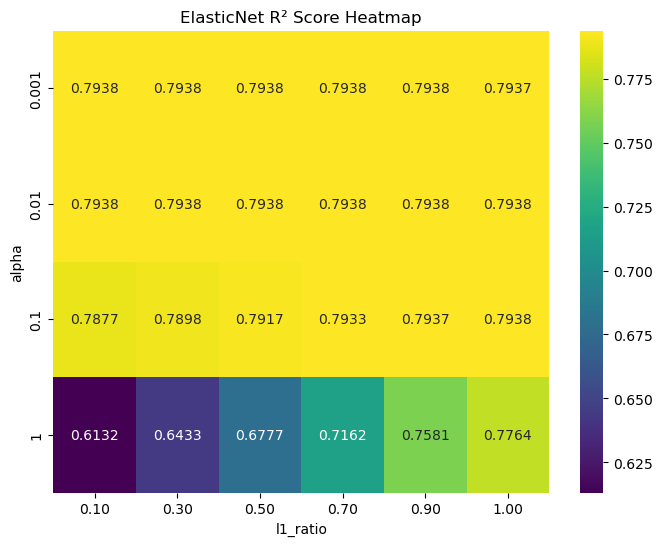

Best alpha: 0.01 best l1_ratio: 0.3
Train R^2: 0.7938343439715394


In [697]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis",
    xticklabels=[f"{c:.2f}" for c in pivot_table.columns],
    yticklabels=[f"{r:g}" for r in pivot_table.index],
)

ax.set_xlabel("l1_ratio")
ax.set_ylabel("alpha")
ax.set_title("ElasticNet R² Score Heatmap")
plt.show()

best_score_en = gridsearch.best_score_
print("Best alpha:", gridsearch.best_params_['alpha'], "best l1_ratio:", gridsearch.best_params_['l1_ratio'])
print("Train R^2:", gridsearch.best_score_)

In [698]:
selector_en, best_score_en_rfecv = rfecv_feature_selection(gridsearch.best_estimator_, X_train, y_train)
X_train_reduced_en = selector_en.transform(X_train)
X_test_reduced_en = selector_en.transform(X_test)

Optimal number of features: 6
Selected features: Index(['scale__passthrough__Water', 'scale__passthrough__Fine Aggregate',
       'remainder__yeojohnson__Age', 'remainder__yeojohnson__Cement',
       'remainder__yeojohnson__Blast Furnace Slag',
       'remainder__yeojohnson__Superplasticizer'],
      dtype='object')
Best R^2 score: 0.7946550161989675


In [699]:
print(f'{best_score_en_rfecv - score_en:.6f} improvement in R^2 on training set')

0.002929 improvement in R^2 on training set


In the ElasticNet stage, we first trained a baseline model using default hyperparameters (alpha = 0.1, l1_ratio = 0.5), which produced a mean cross-validated R² of approximately 0.7917. We then performed a grid search across a range of alpha and l1_ratio values, visualized via a heatmap, which showed that performance was mostly stable for small α values but degraded sharply when alpha = 1. The best combination was found at alpha = 0.01 and l1_ratio = 0.3, giving a slightly improved R^2 of 0.7938. After applying RFECV on the tuned model, the feature set was reduced to six predictors, and the cross-validated score increased marginally to 0.79466, representing an improvement of ~0.003 over the baseline ElasticNet. This confirms that ElasticNet benefits slightly from both hyperparameter tuning and recursive feature elimination, although the overall gain remains small, similar to Lasso and Ridge.

## Model Comparison

In [700]:
results = {
    'Model': ['Linear Regression', 'Lasso', 'Lasso', 'Ridge', 'Ridge', 'ElasticNet', 'ElasticNet'],
    'Type':  ['RFE',               'Base',  'Tuned+RFE','Base',  'Tuned+RFE','Base',       'Tuned+RFE'],
    'R2 Score': [best_score_lr_rfecv, score_l, best_score_l, score_r, best_score_ridge_rfecv, score_en, best_score_en_rfecv],
}

estimators = {
    'Linear Regression': fitted_lr,
    'Lasso': fitted_lasso,
    'Best Lasso': best_estimator_l,
    'Ridge': fitted_ridge,
    'Best Ridge': best_estimator_r,
    'ElasticNet': fitted_en,
    'Best ElasticNet': gridsearch.best_estimator_
}

test_scores = []

for model_name, model in estimators.items():
    if model_name == 'Linear Regression':
        model.fit(X_train_reduced_lr, y_train)
        test_score = model.score(X_test_reduced_lr, y_test)
    elif model_name == 'Best Lasso':
        model.fit(X_train_reduced_lasso, y_train)
        test_score = model.score(X_test_reduced_lasso, y_test)
    elif model_name == 'Best Ridge':
        model.fit(X_train_reduced_ridge, y_train)
        test_score = model.score(X_test_reduced_ridge, y_test)
    elif model_name == 'Best ElasticNet':
        model.fit(X_train_reduced_en, y_train)
        test_score = model.score(X_test_reduced_en, y_test)
    else:
        model.fit(X_train, y_train)
        test_score = model.score(X_test, y_test)

    test_scores.append(test_score)


results['Test Score'] = test_scores


results_df = pd.DataFrame(results)

baseline_score = results_df[(results_df['Model'] == 'ElasticNet') & (results_df['Type'] == 'Base')]['Test Score'].values[0]
results_df['Score Difference'] = results_df['Test Score'] - baseline_score

results_df = results_df.sort_values(by=["Test Score", "R2 Score"], ascending=False).reset_index(drop=True)
results_df

,Model,Type,R2 Score,Test Score,Score Difference
0,Ridge,Base,0.793776,0.816507,0.004650
1,Lasso,Base,0.793778,0.814238,0.002381
2,Ridge,Tuned+RFE,0.794613,0.813218,0.001361
3,ElasticNet,Tuned+RFE,0.794655,0.813008,0.001151
4,Linear Regression,RFE,0.794607,0.812681,0.000824
5,Lasso,Tuned+RFE,0.793778,0.811967,0.000111
6,ElasticNet,Base,0.791726,0.811857,0.000000


After evaluating all models, the results show that Ridge Regression without any hyperparameter tuning or feature selection achieved the strongest overall performance, obtaining the highest test R² score of 0.8165. This is notable because it outperformed more complex versions of the same model, as well as Lasso, ElasticNet, and ordinary least squares with feature elimination. The strong performance of Ridge suggests that the dataset benefits more from L2 regularization, which is known to handle multicollinearity effectively — a likely condition in this dataset, where several concrete mixture components (e.g., cement, slag, fly ash) are naturally correlated.

The base Lasso model produced the second-best performance, confirming that L1 regularization is somewhat useful but still less effective than L2 in this case. Once tuning and feature selection were applied, however, all models — including Lasso, Ridge, and ElasticNet — showed slightly higher training scores but lower test scores, indicating mild overfitting. This means that additional optimization did not generalize better and instead reduced performance on unseen data.

The tuned + RFECV versions of Ridge, Lasso, and ElasticNet did not provide meaningful improvements. Although RFECV improved cross-validated R² by removing three features, the test performance consistently declined. This suggests that the original nine-feature dataset was not suffering from noisy or irrelevant predictors, and removing variables actually discarded useful information. Similarly, ElasticNet tuning revealed that the optimal l1_ratio moved the model closer to Lasso, further reinforcing that L2 regularization is the dominant useful penalty for this problem.

Overall, the best balance between simplicity, interpretability, and predictive performance came from the untuned Ridge model, which required no hyperparameter tuning and no feature reduction. The results illustrate an important takeaway: the simplest model was also the most effective, and additional optimization provided diminishing or negative returns. This outcome reinforces the value of using regularization intelligently rather than assuming “more tuning = better performance.”


## Findings & Interpretation

This project aimed to model the compressive strength of high-performance concrete using multiple linear regression techniques, while also evaluating the impact of data preprocessing, feature selection, and hyperparameter tuning. After cleaning and renaming the dataset for clarity, exploratory analysis revealed that most predictors were skewed and non-normal, especially Age, Fly Ash, and Superplasticizer. To address this, we applied a combination of logarithmic, Yeo-Johnson, and Box-Cox transformations, followed by feature scaling when appropriate. The target variable did not require transformation, preserving interpretability in megapascals (MPa).

We evaluated four regression models: Linear Regression, Lasso, Ridge, and ElasticNet, first using default parameters and then with hyperparameter tuning and recursive feature elimination (RFECV). Across all models, performance was remarkably consistent, with cross-validated R^2 values around 0.79–0.80. However, the simple Ridge model (no tuning, no feature removal) achieved the best test performance, with an R² of 0.8165, outperforming every tuned or pruned version of the same model. In contrast, tuned versions of Lasso, Ridge, and ElasticNet slightly improved training scores but reduced test performance, indicating mild overfitting. RFECV consistently selected the same six features, but removing the other three weakened generalization, suggesting that the full set of predictors was already well-behaved.

The key insight is that this dataset benefits from L2 regularization but not from sparsity or aggressive model optimization. Lasso and ElasticNet provided no meaningful benefit, and neither tuning nor feature selection improved generalization. The results highlight an important principle in applied machine learning: the most complex pipeline is not always the most effective. Here, the best model was also the simplest — a standard Ridge regression with default alpha = 1.0.

## Evaluation & Future Steps

Since simple regularized linear models already achieve strong performance (R^2 0 0.81), adding more complex nonlinear models (SVR, Random Forests, XGBoost) is unlikely to produce major gains unless interaction effects exist.

Future work could include:
- Testing polynomial or interaction terms (e.g. cement × age)
- Bayesian optimization instead of grid search
- Bootstrapping coefficients to quantify uncertainty
- Domain-specific interpretability (e.g. strength sensitivity per kg of cement)